<style>
  .navbar {
    background-color: #f7f7f7;
    display: flex;
    justify-content: space-between;
    align-items: center;
    overflow: hidden;
    font-family: 'Montserrat', 'Arial', sans-serif;
    padding: 10px;
    height: 90px;
    box-shadow: 0 2px 4px rgba(0,0,0,0.2);
  }

  .navbar a {
    font-size: 18px;
    text-align: center;
    padding: 14px 16px;
    text-decoration: none;
    transition: color 0.3s ease-in-out;
    color: #0f5b99
  }

  .navbar a:hover {
    background-color: #eaeaea;
    color: #ff5500;
  }

  .navbar img {
    height: 'auto';
    width: 300px
  }
</style>

<div class="navbar" id="inizio">
  <a href="descrizione_problema.ipynb">Descrizione del problema</a>
  <a href="data_preprocessing.ipynb">Data Preprocessing</a>
  <a href="approccio_3D.ipynb">Approccio 3D</a>
  <a href="approccio_2D.ipynb">Approccio 2D</a>
  <a href="https://www.unipa.it"><img src="https://www.unipa.it/redazioneweb/.content/immagini/logo-unipa-2020.png"></a>
</div>


# <strong> <center> STYLING DEL NOTEBOOK </center> </strong>
---

In [ ]:
from IPython.core.display import HTML

HTML("""
        <style>
            @import url('https://fonts.googleapis.com/css?family=Montserrat&display=swap');
            
            * {
                font-family: 'Montserrat', 'Arial', sans-serif;
                text-align: left;
                line-height: 2em;
            }

        </style>
    """)

## Creazione delle progress bar personalizzate

In [ ]:
bar_format_red = "{l_bar}\x1b[31m{bar}\x1b[0m{r_bar}]"
bar_format_green = "{l_bar}\x1b[32m{bar}\x1b[0m{r_bar}]"
bar_format_yellow = "{l_bar}\x1b[33m{bar}\x1b[0m{r_bar}]"
bar_format_blue = "{l_bar}\x1b[34m{bar}\x1b[0m{r_bar}]"
bar_format_magenta = "{l_bar}\x1b[35m{bar}\x1b[0m{r_bar}]"
bar_format_cyan = "{l_bar}\x1b[36m{bar}\x1b[0m{r_bar}]"

# <center id='paragrafo_8'> <strong> APPROCCIO 3D </strong> </center>
---

## Generazione dei volumi

BLA BLA BLA
Non disponendo delle risorse di calcolo adeguate ai fini di un addestramento di una rete neurale, abbiamo deciso di proseguire la fase di trainig su **Google Colab**, ... 

Per poter esportare i volumi preprocessati senza perdita di informazione, abbiamo deciso di utilizzare un formato particolare, che ci consentisse di risparmiare memoria, BLA BLA BLA

Il formato in questione è il `*.tiff`, BLA BLA BLA

La generazione dei volumi prevede che:

1. Per ogni **gruppo** individuato:

    1. Per ogni **riga** del gruppo:

        1. Si carichi l'immagine di riferimento (scansione o maschera);

        2. Si ridimensioni l'immagine nella forma desiderata (qui $128\times 128$);

        3. Si agganci l'immagine ridimensionata in una lista di immagini.
        
2. Si salvi la lista di immagini in formato `TIFF`.

Per il salvataggio del volume, volendo minimizzare la dimensione dei file risultanti, abbiamo pensato fosse opportuno aggiungere un grado di compressione, ottenuto molto semplicemente aggiungendo il parametro `compression` al metodo `write` e impostandolo a `(DEFLATE, 6)`.

### Elenco `import`

In [ ]:
import os
import pandas as pd
import cv2
import numpy as np
import tifffile as tiff

from tqdm import tqdm

### Elenco `path`

In [ ]:
DATAFRAME_PATH = './dataframes/merged_df_w_segmentation.csv'
VOLUMES_PATH = './dataset/'

### Creazione cartelle

Per automatizzare il processo di generazione di cartelle e sotto-cartelle, utilizziamo la libreria `os` per effettuare dei semplici controlli e, dipendentemente dall'esito, procedere alla creazione della struttura delle directory.

In [ ]:
if not os.path.isdir(VOLUMES_PATH):
    os.mkdir(VOLUMES_PATH)
    
if not os.path.isdir(VOLUMES_PATH + 'slices'):
    os.mkdir(VOLUMES_PATH + 'slices')
    
if not os.path.isdir(VOLUMES_PATH + 'masks'):    
    os.mkdir(VOLUMES_PATH + 'masks')

### Elenco costanti

In [ ]:
IMG_W = 128
IMG_H = 128

Successivamente, si apre il dataframe associato al dataset privo di tutte le scansioni a segmentazione nulla e si raggruppano le righe per caso clinico e giornata di osservazione.

In [ ]:
merged_df = pd.read_csv(DATAFRAME_PATH)

merged_df = merged_df.groupby(['case_id', 'day_id'])

### Scansioni

In [ ]:
print(f'Inizio Creazione \033[1;34mVolumi Slice\033[0m\n')

for group, group_df in tqdm(merged_df, total=len(merged_df), bar_format=bar_format_blue):
    case_id = group_df['case_id'].values[0]
    day_id = group_df['day_id'].values[0]
    volume = []
    for loop_index, (row_index, row) in enumerate(group_df.iterrows()):
        if loop_index == 0:
            width = row['width']
            height = row['height']
        img = cv2.resize(cv2.imread(row['path'], cv2.IMREAD_GRAYSCALE), (IMG_W, IMG_H))        
        volume.append(img)
    depth = len(group_df)
        
    with tiff.TiffWriter(f"{VOLUMES_PATH}slices/volume_{case_id}_{day_id}_128_128_{depth}.tif", bigtiff=True) as tif:    
        tif.write(np.array(volume), compression=('DEFLATE', 6))

print(f'\nFine Creazione \033[1;34mVolumi Slice\033[0m\n')

Inizio Creazione Volumi Slice



100%|██████████| 274/274 [00:18<00:00, 14.82it/s]]


Fine Creazione Volumi Slice



### Maschere

In [ ]:
print(f'Inizio Creazione \033[1;32mVolumi Maschere\033[0m\n')

for group, group_df in tqdm(merged_df, total=len(merged_df), bar_format=bar_format_green):
    case_id = group_df['case_id'].values[0]
    day_id = group_df['day_id'].values[0]    
    volume = []
    
    for loop_index, (row_index, row) in enumerate(group_df.iterrows()):
        if loop_index == 0:
            width = row['width']
            height = row['height']
        img = cv2.resize(cv2.imread(row['mask_path'], cv2.IMREAD_GRAYSCALE), (IMG_W, IMG_H))
        volume.append(img)
    depth = len(group_df)
        
    with tiff.TiffWriter(f"{VOLUMES_PATH}masks/volume_{case_id}_{day_id}_128_128_{depth}.tif", bigtiff=True) as tif:    
        tif.write(np.array(volume), compression=('DEFLATE', 6))

print(f'\nFine Creazione \033[1;32mVolumi Maschere\033[0m\n')

Inizio Creazione Volumi Maschere



100%|██████████| 274/274 [00:08<00:00, 34.10it/s]]


Fine Creazione Volumi Maschere



## Considerazioni preliminari

A seguito dello studio effettuato per la struttura di rete Unet, abbiamo scoperto come questa fosse capace di gestire volumi di profondità variabile. Abbiamo cercato di capire, allora, se le profondità dei volumi fossero particolarmente soggette a variazioni, per cui abbiamo condotto un'analisi statistica 

Inizialmente abbiamo caricato il dataframe generato in fase di data preprocessing:

In [ ]:
DATAFRAME_PATH = '/content/drive/Shareddrives/BIG DATA/PROGETTO_FT/U_Net_3D/dataframes/merged_df.csv'

df = pd.read_csv(DATAFRAME_PATH)

print(f"DATAFRAME ORIGINALE:\n")
df.head()

DATAFRAME ORIGINALE:



,id,case_id,day_id,slice_id,class,segmentation,path,mask_path,slice_name,width,height,width_px,height_px,is_created_mask,is_equalized,white_pixels,black_pixels,white_px/black_px
0,case2_day1_slice_0001,2,1,1,"(0, 1, 2)","(nan, nan, nan)",../BD-Image-Segmentation-Comp/train/case2/case...,../BD-Image-Segmentation-Comp/train/case2/case...,slice_0001_266_266_1.50_1.50.png,266,266,1.5,1.5,True,True,62.0,70694.0,0.000877
1,case2_day1_slice_0002,2,1,2,"(0, 1, 2)","(nan, nan, nan)",../BD-Image-Segmentation-Comp/train/case2/case...,../BD-Image-Segmentation-Comp/train/case2/case...,slice_0002_266_266_1.50_1.50.png,266,266,1.5,1.5,True,True,63.0,70693.0,0.000891
2,case2_day1_slice_0003,2,1,3,"(0, 1, 2)","(nan, nan, nan)",../BD-Image-Segmentation-Comp/train/case2/case...,../BD-Image-Segmentation-Comp/train/case2/case...,slice_0003_266_266_1.50_1.50.png,266,266,1.5,1.5,True,True,74.0,70682.0,0.001047
3,case2_day1_slice_0004,2,1,4,"(0, 1, 2)","(nan, nan, nan)",../BD-Image-Segmentation-Comp/train/case2/case...,../BD-Image-Segmentation-Comp/train/case2/case...,slice_0004_266_266_1.50_1.50.png,266,266,1.5,1.5,True,True,78.0,70678.0,0.001104
4,case2_day1_slice_0005,2,1,5,"(0, 1, 2)","(nan, nan, nan)",../BD-Image-Segmentation-Comp/train/case2/case...,../BD-Image-Segmentation-Comp/train/case2/case...,slice_0005_266_266_1.50_1.50.png,266,266,1.5,1.5,True,True,76.0,70680.0,0.001075


Abbiamo, quindi, voluto vedere quale fosse la **relazione tra la profondità del pixel** registrata e il **numero di slice** per caso clinico e giornata di osservazione

In [ ]:
d1_50 = df.loc[df['width_px'] == 1.50].groupby(['case_id', 'day_id']).size()

for row in pd.DataFrame(d1_50).iterrows():
    if row[1][0] != 144:
        print(f'(Case, Day) {row[0]} has {row[1][0]} slices')

d1_63 = df.loc[df['width_px'] == 1.63].groupby(['case_id', 'day_id']).size()

for row in pd.DataFrame(d1_63).iterrows():
    if row[1][0] != 80:
        print(row[0])

Dall'output della cella si evince che:
1. tutti i casi in cui sono presenti slice con dimensione del pixel pari 1.5 mm appartengono a rilevamenti di 144 slice
2. tutti i casi in cui sono presenti slice con dimensione del pixel pari a 1.63 mm appartengono a rilevamenti di 80 slice

Sono possibili, quindi, solo due valori di partenza.

Abbiamo provato a vedere come cambia la situazione considerando solo le slice segmentate

In [ ]:
non_null_segm_df = df.loc[df['segmentation'] != '(nan, nan, nan)']

d1_50 = non_null_segm_df.loc[non_null_segm_df['width_px'] == 1.50].groupby(['case_id', 'day_id']).size()

print(f"\nIn media, viene mantenuto il {round(np.average(np.array(d1_50.unique(), dtype=np.float16))/144, ndigits=4)*100}% delle \033[1mscansioni a profondità 1.50 mm\033[0m")

d1_63 = non_null_segm_df.loc[non_null_segm_df['width_px'] == 1.63].groupby(['case_id', 'day_id']).size()

print(f"\nIn media, viene mantenuto il {round(np.average(np.array(d1_63.unique(), dtype=np.float16))/80, ndigits=4)*100}% delle \033[1mscansioni a profondità 1.63 mm\033[0m\n")


In media, viene mantenuto il 42.32% delle scansioni a profondità 1.50 mm

In media, viene mantenuto il 58.87% delle scansioni a profondità 1.63 mm



Dai risultati si evince come, in modo non sorprendente rispetto alla fase di data preparation, le slice con dimensione del pixel a 1.50 mm siano generalmente **peggiori qualitativamente** rispetto a quelle con dimensione 1.60 mm (il ché giustificherebbe l'assenza di maschere realizzate manualmente dal personale medico)

Un'altra considerazione che abbiamo dovuto fare, a seguito di ispezione visiva dei file, riguarda la possibilità per cui, in uno stesso caso clinico, possano essere presenti giornate di acquisizione con un **diverso numero di slice**. Abbiamo proceduto, pertanto, a individuare quali casi presentavano profondità variabili

In [ ]:
def filter_function(x):
    return not (x['width_px'].mean() == 1.50 or x['width_px'].mean() == 1.63)

df_grouped_1 = df.groupby(['case_id']).filter(lambda x: filter_function(x)).groupby('case_id')['width_px'].mean()

df_grouped_1.head(20)

case_id
34     1.630000
35     1.589655
89     1.515854
117    1.589655
118    1.528261
131    1.515854
146    1.528261
Name: width_px, dtype: float64

## Statistica dei volumi

Dovendo operare con volumi segmentati, abbiamo continuato la nostra analisi delle profondità

In [ ]:
from tqdm import tqdm

df_case_day = df.loc[df['segmentation'] != '(nan, nan, nan)']

df_case_day = df_case_day.groupby(['case_id', 'day_id'])

volume_depths = []

print(f"\nInizio Costruzione \033[1mArray delle Profondità\033[0m\n")

for group, group_df in tqdm(df_case_day, total=len(df_case_day), bar_format=bar_format_green):
    depth = len(group_df)
    volume_depths.append(depth)
    
volume_depths = np.array(volume_depths, dtype=np.uint8)

print(f"\nFine Costruzione \033[1mArray delle Profondità\033[0m")


Inizio Costruzione Array delle Profondità



100%|██████████| 274/274 [00:00<00:00, 20698.06it/s]]


Fine Costruzione Array delle Profondità


Da cui risulta che

In [ ]:
print(f"\nIn \033[4mmedia\033[0m, i volumi hanno profondità pari a {np.mean(volume_depths).astype(np.uint8)} slices.")

print(f"\nLa \033[4mprofondità massima\033[0m registrata è di {np.max(volume_depths).astype(np.uint8)} slices")

print(f"\nLa \033[4mprofondità minima\033[0m registrata è di {np.min(volume_depths).astype(np.uint8)} slices")

print(f"\nLa \033[4mmoda\033[0m delle profondità è di {np.argmax(np.bincount(volume_depths.astype(np.uint8))).astype(np.uint8)}")

scarto_q_medio = np.uint8(np.sqrt(np.square(np.subtract(volume_depths, np.mean(volume_depths).astype(np.uint8) * np.ones(len(volume_depths)))).mean()))

print(f"\nSi registra uno \033[4mscarto quadratico medio\033[0m di {scarto_q_medio} slices")


In media, i volumi hanno profondità pari a 60 slices.

La profondità massima registrata è di 88 slices

La profondità minima registrata è di 30 slices

La moda delle profondità è di 61

Si registra uno scarto quadratico medio di 11 slices


Presentiamo in forma grafica quanto appena trovato

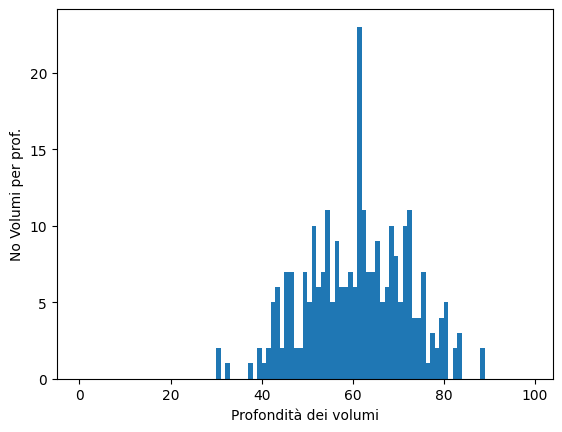

In [ ]:
from matplotlib import pyplot as plt

plt.hist(volume_depths.astype(np.uint8), bins=[_ for _ in range(100)], histtype='bar')
plt.xlabel(f'Profondità dei volumi')
plt.ylabel(f'No Volumi per prof.')
plt.show()

Vista una tale diversificazione nelle profondità, ci siamo posti il problema se, e a quanto, fosse necessario **uniformare le profondità dei volumi**.

Dopo una valutazione della distribuzione statistica degli elementi, da cui si evince una gaussiana a media 60, e visto che Unet-3D opera bene con profondità che sono potenza di 2, abbiamo deciso di uniformare la profondità dei volumi alla **potenza di 2 più vicina alla media**, ossia $2^6 = 64$, accettando piccoli tagli di informazione per i volumi più profondi e riducendo di molto il numero di padding nero necessario per i volumi più piccoli che si sarebbe avuto nel caso la profondità scelta fosse stata di 128 slice/volume

## Ridimensionamento dei volumi

Avendo convenuto sulla profondità unica per i volumi, abbiamo dovuto implementare una strategia incrementare la profondità dei volumi più piccoli fino a quella desiderata, e un'altra per il ritaglio dei volumi più grandi che consentisse di mantenere il maggior numero di informazioni, ossia di maschere.

Nel primo caso, abbiamo optato per una strategia di **zero-padding**, per cui abbiamo aggiunto intorno al volume un numero di slice nere variabile, pari a $64 - |V|$, per $V$ volume.

Nel secondo caso, abbiamo notato che le slice più segmentate (ossia che presentano il maggior numero di organi segmentati) sono quelle "di mezzo", mentre le slice iniziali e finali tendono ad avere un solo organo segmentat. Per questo motivo, abbiamo deciso di **tagliare** un numero variabile di slice **intorno al centro del volume**, in modo da preservare la maggior parte delle informazioni.

### Elenco `import`

In [ ]:
from glob import glob
from tqdm import tqdm

### Elenco `path`

In [ ]:
MASKS_SOURCE_PATH = '/content/drive/Shareddrives/BIG DATA/PROGETTO_FT/U_Net_3D/volumes/masks/'

MASKS_DEST_PATH = '/content/drive/Shareddrives/BIG DATA/PROGETTO_FT/U_Net_3D/resized_volumes/masks/'

SLICES_SOURCE_PATH = '/content/drive/Shareddrives/BIG DATA/PROGETTO_FT/U_Net_3D/volumes/slices/'

SLICES_DEST_PATH = '/content/drive/Shareddrives/BIG DATA/PROGETTO_FT/U_Net_3D/resized_volumes/slices/'

In [ ]:
DESIRED_SHAPE = (64, 256, 256)

def zero_pad_resize_tif(original_volume: np.ndarray, desired_shape:tuple[int,int,int], output_file: str, debug=False):

    depth, height, width = original_volume.shape

    desired_depth = desired_shape[0]

    resized_volume = np.zeros(desired_shape)
    if debug is True:
      print(f'\n* \033[1mDimensione iniziale\033[0m del volume: {original_volume.shape}\n')

    if depth > desired_depth:
        start = int((depth - desired_depth) / 2)
        end = start + desired_depth
        resized_volume[:, :, :] = original_volume[start:end, :, :]
    else:
        start = int((64 - depth) / 2)
        end = start + depth
        resized_volume[start:end, :, :] = original_volume
    if debug is True:
      print(f'* \033[1mDimensione finale\033[0m del volume: {resized_volume.shape}\n')

    if output_file is not None:
        with tiff.TiffWriter(output_file, bigtiff=True) as tif:
            tif.write(np.array(resized_volume, dtype=np.uint8), compression=('DEFLATE', 6))
            if debug is True:
              print(f"\033[1mSalvato\033[0m Volume Ridimensionato in {output_file}\n")

    return resized_volume


Per quanto concerne l'effettivo ridimensionamento dei volumi, esso avviene secondo il seguente listato

In [ ]:
ORIGINAL_MASKS = glob(MASKS_SOURCE_PATH + '*.tif')
ORIGINAL_SLICES = glob(SLICES_SOURCE_PATH + '*.tif')

print("* Inizio Creazione \033[1mVolumi Ridimensionati delle Maschere\033[0m\n")

for filename in tqdm(ORIGINAL_MASKS, total=len(ORIGINAL_MASKS), bar_format=bar_format_green):
    volume = tiff.imread(filename)
    filename_splits = filename.split('/')

    zero_pad_resize_tif(original_volume=volume, desired_shape=DESIRED_SHAPE, output_file=MASKS_DEST_PATH + 'resized_' + filename_splits[-1])

print("\n* Fine Creazione \033[1mVolumi Ridimensionati delle Maschere\033[0m\n")

print("\n* Inizio Creazione \033[1mVolumi Ridimensionati delle Slice\033[0m\n")

for filename in tqdm(ORIGINAL_SLICES, total=len(ORIGINAL_SLICES), bar_format=bar_format_blue):
    volume = tiff.imread(filename)
    filename_splits = filename.split('/')

    zero_pad_resize_tif(original_volume=volume, desired_shape=DESIRED_SHAPE, output_file=SLICES_DEST_PATH + 'resized_' + filename_splits[-1])

print("\n* Fine Creazione \033[1mVolumi Ridimensionati delle Slice\033[0m\n")

print(f"\nSono Stati Generati i Volumi di Dimensione \033[1m{(64, 128, 128)}\033[0m\n")

* Inizio Creazione Volumi Ridimensionati delle Maschere



100%|██████████| 274/274 [02:10<00:00,  2.10it/s]]



* Fine Creazione Volumi Ridimensionati delle Maschere


* Inizio Creazione Volumi Ridimensionati delle Slice



100%|██████████| 274/274 [02:57<00:00,  1.55it/s]]


* Fine Creazione Volumi Ridimensionati delle Slice


Sono Stati Generati i Volumi di Dimensione (64, 128, 128)



## **U-Net 3D** - Primo approccio

Per la segmentazione di immagini tridimensionali, il modello principe è **U-Net 3D**.

L'architettura U-Net è composta da un **encoder**, un **bottleneck** e un **decoder**. 
1. L'encoder è una serie di blocchi convoluzionali seguiti da una max-pooling, che riducono la dimensione della feature map e aumentano il numero di filtri. Questi blocchi catturano le caratteristiche delle immagini di input a diverse scale. La max-pooling riduce la risoluzione spaziale delle feature map, ma mantiene le caratteristiche di alto livello.

2. Il bottleneck è un blocco convoluzionale che riduce la dimensione della feature map in modo significativo, ma mantiene le caratteristiche di alto livello. Questo blocco è importante per ridurre il numero di parametri e prevenire l'overfitting.

3. Il decoder è una serie di blocchi convoluzionali seguiti da una convoluzione trasposta, che ricostruisce la dimensione della feature map e riduce il numero di filtri. Questi blocchi fondono le informazioni delle feature map di diverse scale e ricostruiscono l'immagine di output. La convoluzione trasposta è utilizzata per aumentare la risoluzione spaziale della feature map.

Infine, l'**output** è una convoluzione 3D con un kernel di dimensione $1\times 1\times 1$ e una funzione di attivazione **softmax**, che restituisce una distribuzione di probabilità su tutte le classi di output.

Nel nostro caso, l'implementazione del modello è stata **manuale**, basandoci sulla struttura appena descritta, secondo il listato seguente.

Per il nostro caso d'uso, abbiamo stabilito che l'`input_shape` predefinito è `(64, 128, 128, 1)`, che indica che l'input è un volume tridimensionale con dimensioni $64\times 128\times 128$ in scala di grigi. Il parametro `num_classes` indica il numero di classi di output, mentre `filters` indica il numero di filtri per ciascuna convoluzione.

Tutti gli elementi dei vari layer (`Conv3D`, `MaxPooling3D`, ecc.) sono stati importati dal modulo `keras.layers`, mentre l'oggetto `Input` e il modello vero e proprio `Model` sono stati importati dal modulo `keras`.


<center><img src="https://www.researchgate.net/profile/Mobarakol-Islam/publication/350625751/figure/fig1/AS:1009070836285440@1617592643115/Our-proposed-segmentation-architecture-3D-attention-UNet-by-composing-of-sequential.png"</center> 

### Elenco `import`

In [ ]:
import cv2
import numpy as np

from glob import glob
from sklearn.model_selection import train_test_split

# Keras
from keras.layers import Conv3D, BatchNormalization, MaxPooling3D, Conv3DTranspose, concatenate
from keras import Model, Input
import keras.backend as K

# TensorFlow
import tensorflow as tf

### Elenco `path`

In [ ]:
VOLUMES_PATH = sorted(glob('./dataset/slices/*.tif'))
MASKS_PATH = sorted(glob('./dataset/masks/*.tif'))

print(f'Sono presenti {len(VOLUMES_PATH)} volumi di scansioni\n')
print(f'Sono presenti {len(MASKS_PATH)} volumi di maschere\n')

Sono presenti 274 volumi di scansioni

Sono presenti 274 volumi di maschere



### Modello

In [ ]:
def unet_3d(input_shape=(64, 128, 128, 1), num_classes=4, filters=16):
    inputs = Input(shape=input_shape)
    x = inputs

    # Encoder
    skips = []
    for depth in range(4):
        x = Conv3D(filters, 3, activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = Conv3D(filters, 3, activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        skips.append(x)
        x = MaxPooling3D(2)(x)
        filters *= 2

    # Bottleneck
    x = Conv3D(filters, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv3D(filters, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    # Decoder
    for depth in range(3, -1, -1):
        filters //= 2
        x = Conv3DTranspose(filters, 2, strides=(2, 2, 2), padding='same')(x)
        x = concatenate([skips[depth], x])
        x = Conv3D(filters, 3, activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = Conv3D(filters, 3, activation='relu', padding='same')(x)
        x = BatchNormalization()(x)

    # Output
    outputs = Conv3D(num_classes, 1, activation='softmax')(x)

    # Model
    model = Model(inputs=inputs, outputs=outputs)

    return model

model = unet_3d()

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 128, 12  0           []                               
                                8, 1)]                                                            
                                                                                                  
 conv3d (Conv3D)                (None, 64, 128, 128  448         ['input_1[0][0]']                
                                , 16)                                                             
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 128, 128  64         ['conv3d[0][0]']                 
 alization)                     , 16)                                                         

### Metriche

Per quanto concerne le metriche di valutazione dell'apprendimento e, successivamente, del testing, abbiamo voluto utilizzare due metriche, che sono considerate di riferimento nell'ambito della *image segmentation*, ossia il **coefficiente di Dice** e la **distanza di Hausdorff** (in questo caso implementata nella sua variante 3D).

Il coefficiente di Dice, chiamato anche indice di Dice o **F1 score**, è una metrica di valutazione della similarità tra due insiemi di dati (qui immagini), ed è definito come il rapporto tra il doppio dell'area di intersezione tra i due insiemi e la somma delle aree dei due insiemi, o meglio 
$$ Dice(X,Y) = 2\cdot \frac{|X∩Y|}{|X|+|Y|}$$

In altre parole, misura la **sovrapposizione tra i risultati ottenuti** dall'algoritmo **e la ground truth**, normalizzato rispetto alla dimensione dei due insiemi. Il valore del coefficiente di Dice varia tra 0 e 1, dove 1 indica una perfetta sovrapposizione e 0 indica una completa disuguaglianza.<br>
In generale, quindi, un alto valore di coefficiente di Dice indica una buona performance dell'algoritmo di segmentazione, mentre un valore basso indica una scarsa performance.

La distanza di Hausdorff, invece, viene calcolata come la **distanza massima tra i punti di un volume rispetto ai punti del volume di riferimento**. In altre parole, la distanza di Hausdorff rappresenta la massima distanza geometrica tra due volumi 3D, secondo la formula 
$$ H(A,B) = \max(h(A,B),\ h(B,A)) $$

dove $h(A,B)$ e $h(B,A)$ sono, rispettivamente, la **distanza diretta** di Hausdorff da A a B e la distanza inversa da B ad A.<br>
La distanza di Hausdorff è un'importante metrica di valutazione della performance per la segmentazione di volumi 3D, in quanto tiene conto della massima discrepanza tra il volume segmentato e quello di riferimento. In generale, un **basso valore** di distanza di Hausdorff indica una **buona performance** dell'algoritmo di segmentazione, mentre un alto valore indica una scarsa performance.

Nella cella seguente sono presenti i listati delle due funzioni usate per il calcolo delle metriche, implementate attraverso operazioni aggregate di TensorFlow.


In [ ]:
def hausdorff_3d(y_true, y_pred):

    # calcola la distanza di Hausdorff diretta tra i due insiemi
    d_hd1 = tf.reduce_max(tf.norm(tf.subtract(y_true, y_pred)))
    # calcola la distanza di Hausdorff inversa
    d_hd2 = tf.reduce_max(tf.norm(tf.subtract(y_pred, y_true)))
    # restituisce la distanza di Hausdorff simmetrica
    
    return tf.reduce_max(tf.stack([d_hd1, d_hd2]))

def dice_coefficient(y_true, y_pred, epsilon=1e-6):
  y_true = tf.cast(y_true, tf.float32)
  y_pred = tf.cast(y_pred, tf.float32)

  intersection = tf.reduce_sum(y_true * y_pred)
  sum_ = tf.reduce_sum(y_true + y_pred)

  dice = tf.reduce_mean((2. * intersection + epsilon) / (sum_ + epsilon)) # si effettua una media
  return dice

### Train/Test split

Non avendo a disposizione un test set dalla competizione, procediamo ad una suddivisione *artificiale* del training set, sfruttando la funzione `train_test_split` di Scikit-Learn, scegliendo come percentuale di test un valore compreso tra il 10% e il 20% (come da prassi in questo genere di problemi).

Nello specifico, abbiamo optato per una percentuale del 15%.

Successivamente, ricaviamo anche un validation set per la fase di validazione durante l'addestramento della rete, con una percentuale globale del 10% circa (12,5% del training set residuo).

**DIVISIONE EFFETTIVA**: 75% - 10% - 15%

In [ ]:
train_files_paths, test_files_paths, train_labels_paths, test_labels_paths =\
  train_test_split(VOLUMES_PATH, MASKS_PATH, test_size=0.15, random_state=11)
  
print(f'Saranno usate \033[1;34m{len(test_files_paths)}\033[0m coppie (scansione, maschera) come \033[1;34mtest set\033[0m\n')

train_files_paths, validation_files_paths, train_labels_paths, validation_labels_paths =\
  train_test_split(train_files_paths, train_labels_paths, test_size=0.125, random_state=11)

print(f'Saranno usate \033[1;34m{len(train_files_paths)}\033[0m coppie (scansione, maschera) come \033[1;34mtraining set\033[0m\n')

print(f'Saranno usate \033[1;34m{len(validation_files_paths)}\033[0m coppie (scansione, maschera) \033[1;34mvalidation set\033[0m\n')

Saranno usate 42 coppie (scansione, maschera) come test set

Saranno usate 203 coppie (scansione, maschera) come training set

Saranno usate 29 coppie (scansione, maschera) validation set



### Data Generation & Augmentation

Per quanto concerne la parte di **data augmentation**, le alterazioni delle immagini che abbiamo ritenuto probabili per il problema in analisi sono:

1. *Rotazioni*, per cui abbiamo stimato (in eccesso) valori possibili di $\pm$ 15°, dovute a possibili movimenti del paziente durante la scansione o a errori di posizionamento dello stesso;
2. *Traslazioni* lungo gli assi $x$ e $y$, per cui abbiamo stimato valori possibili di $\pm$ 10px, imputabili alle stesse cause delle rotazioni;
3. *Flip orizzontale*, possibile solo per scelta degli operatori in fase di acquisizione
4. *Rumore*, nello specifico si è scelto il rumore di Rician perché...

Per implementare queste distorsioni, abbiamo realizzato la funzione `augment_data`, che accetta in input una coppia di volumi (scansioni e maschere corrispondenti) su cui vengono applicate le trasformazioni 1, 2 e 3 in modo casuale, mentre il rumore di Rician può essere applicato **solo alle scansioni**, dato che le maschere fornite sono realizzate manualmente dai tecnici.

**N.B.**: l'implementazione del rumore di Rician è stata effettuata con produzione autonoma della funzione `add_rician_noise`

In [ ]:
def add_rician_noise(img, noise_std=15):

    '''
        In questo caso, mean=0 perché il rumore gaussiano che viene generato ha media zero, ovvero è un rumore gaussiano bianco. 
        Il rumore di Rician viene generato come una combinazione di due rumori gaussiani, quindi se uno di questi rumori ha una 
        media diversa da zero, il rumore di Rician generato avrà una media diversa da zero. Tuttavia, per la maggior parte delle 
        applicazioni di aggiunta di rumore, si assume che il rumore abbia una media zero. In questo modo, il rumore aggiunto non 
        altera la distribuzione dei livelli di grigio dell'immagine originale.
    '''

    mean = 0

    # Genera rumore di Rician
    # 1. Genera rumore gaussiano bianco
    noise = np.random.normal(mean, noise_std, img.shape)
    noise = np.abs(noise + 1j * np.random.normal(mean, noise_std, img.shape))
    noise = noise / np.sqrt(2)

    # Aggiungi rumore all'immagine
    noisy_img = img + noise
    
    return noisy_img

In [ ]:
def augment_data(slice_volume:np.ndarray, mask_volume:np.ndarray, debug=False) -> tuple[np.ndarray]:
    """Funzione usata per la data augmentation.
    
    Le trasformazioni avvengono in modo casuale per la coppia di volumi (slice, maschera).
    Tra le trasformazioni possibili abbiamo:
    
        - Rotazione +/- 15 gradi
        - Traslazione +/- 5px
        - Flip orizzontale
        - Aggiunta del rumore di Rician (solo per slice_volume)

    Args:
        slice_volume (np.ndarray): Volume di slice su cui fare la augmentation
        mask_volume (np.ndarray): Volume di maschere su cui fare la augmentation

    Returns:
        tuple[np.ndarray]: Coppia di volumi (slice, maschere) aumentati
    """
    
    data_rotation = round(np.random.uniform(-15, 15))
    data_traslation_x = round(np.random.uniform(-5, 5))
    data_traslation_y = round(np.random.uniform(-5, 5))
    horizontal_flip = round(np.random.uniform(0, 1))
    adds_rician_noise = round(np.random.uniform(0, 1))
    
    if debug is True:
        print(f'Rotating of {data_rotation} degrees\n')
        print(f'Translating over (x,y) of ({data_traslation_x, data_traslation_y})\n')
        print(f'Does horizontal flip: {horizontal_flip}\n')
        print(f'Adds Rician noise: {adds_rician_noise}\n')
    
    affine_trasl_matrix = np.float32(
        [[1,0,data_traslation_x], 
         [0,1,data_traslation_y]]
        )
    
    augm_slice = []
    augm_masks = []
    
    for slice in slice_volume:
        # Traslazione
        slice = cv2.warpAffine(slice, affine_trasl_matrix, (slice.shape[0], slice.shape[1]))
        # Rotazione
        slice_center = tuple([slice.shape[0]/2, slice.shape[1]/2])
        rotation_matrix = cv2.getRotationMatrix2D(slice_center, data_rotation, 1.0)
        # Flip orizzontale
        if horizontal_flip == 1:
            slice = cv2.flip(slice, 1)
        # Aggiunta rumore di Rician
        if adds_rician_noise == 1:    
            slice = add_rician_noise(slice)
            
        augm_slice.append(slice)
        
    for mask in mask_volume:
        # Traslazione
        mask = cv2.warpAffine(mask, affine_trasl_matrix, (mask.shape[0], mask.shape[1]))
        # Rotazione
        mask_center = tuple([mask.shape[0]/2, mask.shape[1]/2])
        rotation_matrix = cv2.getRotationMatrix2D(mask_center, data_rotation, 1.0)
        mask = cv2.warpAffine(mask, rotation_matrix, (mask.shape[0], mask.shape[1]))
        # Flip orizzontale
        if horizontal_flip == 1:
            mask = cv2.flip(mask, 1)
        augm_masks.append(mask)
    
    augm_slice = np.array(augm_slice)
    augm_masks = np.array(augm_masks)
    
    return augm_slice, augm_masks

In aggiunta, abbiamo dovuto definire una nostra versione della funzione `to_categorical`, che genera una rappresentazione one-hot-encoded di un volume passato in input, per questioni di compatibilità e di adattamento dei dati al framework `keras`.

Per gli scopi del progetto, il **numero di classi** scelto è 4, laddove la quarta classe è, in realtà, lo sfondo della maschera di segmentazione.

In [ ]:
def custom_to_categorical(volume: np.ndarray, num_classes=4, debug=False) -> np.ndarray:
  """Funzione usata per generare una rappresentazione one-hot-encoded di un volume

  Args:
      volume (np.ndarray): Volume di cui ottenere la rappresentazione one-hot
      num_classes (int, optional): Numero di classi di segmentazione da individuare. Default a 4.
      debug (bool, optional): Flag di debug. Default a False.

  Returns:
      np.ndarray: Volume in rappresentazione one-hot
  """
  
  
  categorical_volume = np.zeros_like(volume[:,:,:,np.newaxis])
  
  categorical_volume_0 = categorical_volume
  
  for i in range(num_classes-1):
    categorical_volume = np.concatenate([categorical_volume, categorical_volume_0], axis=3)
  
  if debug is True:
    print(categorical_volume.shape)
  
  for i in range(volume.shape[0]):
    volume_slice = volume[i]
    
    categorical_volume[i, volume_slice[:,:] < 80, 0] = 255
    if debug is True:
      print(f'Saved values of class 0\n')
      
    categorical_volume[i, np.logical_and(volume_slice[:,:] == 80, volume_slice[:,:] < 160), 1] = 255
    if debug is True:
      print(f'Saved values of class 1\n')
      
    categorical_volume[i, np.logical_and(volume_slice[:,:] == 160, volume_slice[:,:] < 240), 2] = 255
    if debug is True:
      print(f'Saved values of class 2\n')
      
    categorical_volume[i, volume_slice[:,:] == 240, 3] = 255
    if debug is True:
      print(f'Saved values of class 3\n')
  
  if debug is True:
    print(f"Created volume one-hot-encoded of shape: {categorical_volume.shape}\n")
  
  return np.array(categorical_volume, dtype=object)  

Per poter passare in input alla rete neurale tutto il dataset, senza saturare le risorse dei sistemi in uso, abbiamo deciso di implementare un DataGenerator customizzato per le nostre esigenze.
Il problema di fondo è, infatti, che i data generator implementati nella classe `ImageDataGenerator` del modulo `keras.preprocessing.image` non sono pensati per operare con volumi 3D nè, tantomeno, hanno metodi che permettono di operare su singoli volumi `.tif`.

Abbiamo, quindi, implementato una nuova classe `TiffDataGenerator`, che estende la classe `Sequence` di `keras.utils`, che riceve in input due percorsi e, opzionalmente, una `batch_size` e un flag per indicare se si vuole eseguire lo `shuffle` dei dati alla fine di ogni generazione.

Il metodo `__getitem__` è quello che provvede alla generazione vera e propria dei dati da dare in pasto alla rete, in quanto implementa le già viste funzioni di data augmentation e converte i dati del volume della maschera nel formato *one-hot*, che è molto utile per problemi multiclasse.



In [ ]:
import tifffile as tiff
from keras.utils import Sequence

class TiffDataGenerator(Sequence):
    def __init__(self, tif_path_list, batch_size=1, shuffle=True):
        self.tif_path_list = tif_path_list
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.tif_path_list))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.tif_path_list) / self.batch_size))

    def __getitem__(self, index):
        batch_indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        batch_paths = [self.tif_path_list[k] for k in batch_indexes]
        batch_volumes = []
        batch_masks = []
        for path in batch_paths:
            volume = tiff.imread(path[0]) / 255.0
            mask = tiff.imread(path[1])
            
            volume, mask = augment_data(volume, mask)
            mask = custom_to_categorical(mask, num_classes=4)

            volume = volume.reshape((1,) + volume.shape + (1,))
            mask = mask.reshape((1,) + mask.shape)

            batch_volumes.append(volume)
            batch_masks.append(np.asarray(mask / 255.0).astype(np.float16))

        return np.vstack(batch_volumes), np.vstack(batch_masks)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

    @classmethod
    def from_paths(cls, volume_paths, mask_paths, batch_size=1, shuffle=True):
        if len(volume_paths) != len(mask_paths):
            raise ValueError("Il numero dei volumi nel batch deve essere uguale al numero di maschere")
        return cls(list(zip(volume_paths, mask_paths)), batch_size=batch_size, shuffle=shuffle)

### Parametri del modello e addestramento

<div style="display: flex; align-items: center; text-align: center">
  <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/d0/Google_Colaboratory_SVG_Logo.svg/1280px-Google_Colaboratory_SVG_Logo.svg.png" width='10%' height='10%'>
  <h3 style="margin: 0 0 0 40px;">Parametri del modello e addestramento</h3>
</div>

Per quanto concerne i parametri del modello di Unet-3D descritto poc'anzi, quelli su cui abbiamo deciso di intervenire sono:
* la `batch_size`, ossia il numero di coppie volumi passati in input alla rete, per cui abbiamo stabilito un valore di 8 (corrispondenti al caricamento di tensori di forma $16\times 64\times 128\times 128$), in modo da non saturare la RAM della GPU e comunque avere un numero decente di volumi per sessione di addestramento,
* il numero di `epochs`, ossia il numero di *passate* che il modello effettua sul dataset ricevuto in input, fissato ad un valore ritenuto elevato (nello specifico 300 `epochs`).

In [ ]:
BATCH_SIZE = 4
EPOCHS = 300
CHECKPOINT_DIR = '/content/drive/Shareddrives/BIG DATA/PROGETTO_FT/U_Net_3D/models/checkpoints/checkpoint.hdf5'
LOG_DIR = '/content/drive/Shareddrives/BIG DATA/PROGETTO_FT/U_Net_3D/models/logs/history_log.csv'

Successivamente, abbiamo definito le strategie di apprendimento dinamico che la rete avrebbe dovuto seguire attraverso l'implementazione di funzioni di callback. Nello specifico:

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.losses import CategoricalCrossentropy
from keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

* *Early Stopping*, ossia la strategia per cui l'addestramento su un batch termina nel momento in cui una metrica sotto osservazione non migliora in modo sufficiente per un determinato numero di epoche. Prevedendo un comportamento diverso nelle prime fasi dell'addestramento (dove l'apprendimento risulta molto più rapido) e nelle fasi successive (dove i miglioramenti diventano meno palpabili), abbiamo implementato due oggetti della classe `EarlyStopping` del modulo `keras.callbacks` in cui sono attuate queste strategie (rispetto al monitoraggio della `val_loss`):
  1. In `early_stopping_start` abbiamo stabilito un `min_delta`, ossia una variazione minima del parametro per il periodo di osservazione, più elevato e una `patience` più bassa, per far sì che il modello fosse lasciato libero di apprendere senza incorrere in overfitting;
  2. In `early_stopping_late` abbiamo stabilito un `min_delta` decisamente più basso, aumentando il numero di epoche per la `patience`, in modo da permettere al modello di registrare variazioni significative della `val_loss`.

In [ ]:
# PRIME FASI ADDESTRAMENTO
# early_stopping = EarlyStopping(
#   monitor='val_loss', 
#   patience=3, 
#   min_delta=100
# )

# FASI SUCCESSIVE ADDESTRAMENTO
early_stopping = EarlyStopping(
  monitor='val_loss', 
  patience=5, 
  min_delta=0.01
)

* *Exponential Decay*, ossia la strategia di variazione dinamica del learning rate in forma esponenziale, secondo la formula $$f (x) = a (1 + r)^x$$ dove:
  1. $a$ è il learning rate iniziale, con cui inizia ogni epoca
  2. $r$ è il tasso di variazione, con cui si determina la base della funzione esponenziale di variazione del `LR`
  3. $x$ è il numero di intervalli di tempo per cui calcolare il valore aggiornato del `LR`

In [ ]:
decayed_lr = ExponentialDecay(
  initial_learning_rate=1e-3, 
  decay_steps=13,
  decay_rate=0.95, 
  staircase=False
)

adam = Adam(
  learning_rate=decayed_lr
)

* *Model Checkpoint*, ossia uno strumento utile per mantenere i progressi del modello in fase di training. Nello specifico, abbiamo deciso di utilizzare un oggetto `ModelCheckpoint` del modulo `keras.callbacks`, che salva il checkpoint in una directory passata in input secondo delle modalità stabilite manualmente.<br>Innanzitutto, bisogna stabilire un `monitor`, ossia la quantità da valutare per stabilire quale checkpoint salvare; successivamente bisogna stabilire se salvare tutti i checkpoints di tutte le epoche, o solamente il migliore nel monitoraggio, attraverso il parametro `save_best_only`; infine, si deve stabilire se, nel file generato, si vogliono salvare solo i pesi della rete oppure l'intero modello attraverso il parametro `save_weights_only`

In [ ]:
model_checkpoint = ModelCheckpoint(
  filepath = CHECKPOINT_DIR,
  monitor = 'val_loss', 
  save_best_only = True,
  save_weights_only = False
)

Infine, passiamo all'addestramento vero e proprio del modello attraverso il metodo `fit` dell'oggetto `keras.Model`, cui passiamo in input:
* il Data Generator per il `train_set`, contenente i volumi sia delle scansioni che delle maschere (ossia le ground truths per il modello),
* il numero di epoche,
* dei `validation_data`, inseriti in quanto `model.fit` non supporta la `validation_split` quando riceve in input elementi di tipo `Sequence`, ottenuti attraverso una nuova istanza del Data Generator specifica per i percorsi di validazione ottenuti con la suddivisione fatta in precedenza,
* le funzioni di Callback definite in precedenza e un numero di `steps_per_epoch` (di default pari a `len(dataset)/BATCH_SIZE`) posto a un valore arbitrario.

Il metodo `fit` prevede anche un parametro `verbose`, che accetta valori tra 0 e 2, con cui si rende l'output del metodo più ricco di informazioni utili in fase di ottimizzazione del modello. In una prima fase tale parametro viene impostato pari a 2, ossia il livello massimo di verbosità dell'output, salvo poi essere impostato, ai fini di una maggiore facilità di comprensione e di una migliore presentazione del notebook, a 1.

**N.B.** per garantire un addestramento continuo con le risorse a disposizione, si è deciso di integrare tutta la parte di caricamento del checkpoint, addestramento, salvataggio del checkpoint e logging all'interno di un ciclo python `while True`

In [ ]:
import os

train_files_generator = TiffDataGenerator.from_paths(
  train_files_paths,
  train_labels_paths, 
  batch_size=BATCH_SIZE
)

validation_files_generator = TiffDataGenerator.from_paths(
  validation_files_paths, 
  validation_labels_paths, 
  batch_size=BATCH_SIZE
)

while True:
  model = unet_3d()

  model.compile(optimizer=adam, metrics=[hausdorff_3d, dice_coefficient], loss='categorical_crossentropy')

  if os.path.isfile(CHECKPOINT_DIR):
    model.load_weights(CHECKPOINT_DIR)
    print(f'\nCaricato il checkpoint in \033[1;34m{CHECKPOINT_DIR}\033[0m\n')

  history = model.fit(
    train_files_generator, 
    epochs=EPOCHS,
    validation_data=[validation_files_generator],
    workers = 1,
    verbose=2, 
    callbacks=[early_stopping, model_checkpoint]
  )

  print(f'\nGenerato checkpoint in \033[1;34m{CHECKPOINT_DIR}\033[0m\n')
  print('-------------------------------------------------------------------\n')

  import pandas as pd

  pd.DataFrame(history.history).to_csv(LOG_DIR)

> #### Variazioni dell'Early Stopping

Come parametro di valutazione per l'early stopping abbiamo scelto la `val_loss`. Quello che resta da determinare è la variazione minima del parametro e il numero di epoche da attenzionare come periodo di valutazione, rispettivamente rappresentati dal `min_delta` e dalla `patience`.

1. Inizialmente, abbiamo posto il `min_delta` pari a `0.01` per una patience di `5 epochs`, ma il risultato è stato un **overfitting** della rete già al primo batch;

2. Abbiamo pensato, quindi, di abbassare il numero di `epochs` per la `patience`, portandolo a `3`, tarando il `min_delta` verso l'alto (per esempio `0.05`), in modo da evitare l'overfitting dopo solo **8 volumi**, ma l'addestramento in fase primordiale ha allungato sensibilmente i tempi.

3. Infine, abbiamo ideato la strategia descritta poc'anzi, per cui abbiamo tarato ulteriormente verso l'alto il `min_delta`, portandolo a `100`, ma abbiamo introdotto un secondo oggetto `EarlyStopping` per le fasi successive dell'addestramento, con un `min_delta` molto più basso, pari a `0.01`, e incrementando il numero di epoche di `patience`, adesso pari a `5`.



> #### Variazioni Learning Rate Scheduling

Come valore iniziale del `learning_rate` si è scelto `1e-3`, pensando ad una discesa del valore esponenziale attraverso una strategia di scheduling nota come **Exponential Decay**, implementata attraverso la classe omonima del pacchetto `tensorflow.keras.optimizers.schedules`.<br>
Come $\Delta _t$ per effettuare la variazione, si è dovuto scegliere un valore proporzionale al rapporto $\frac{\text{len}(D_s)}{|B|}$ , qui pari a 26. In una prima fase dell'addestramento si è voluto scegliere 13 come valore per `decay_steps`, mentre in una seconda fase, dopo che sono stati passati i primi volumi, tale valore è stato portato a 2.
Come fattore di variazione, si è deciso di mantenere per tutta la durata dell'addestramento un valore di 0.95 per il `decay_rate`.


### Valutazioni sull'addestramento

Poiché il numero di volumi si è rivelato particolarmente basso e il numero di possibili trasformazioni rendevano estremamente variabili i vari campioni del training set, l'addestramento di un modello Unet-3D vergine si è rivelato particolarmente infruttuoso, fornendo metriche gravemente insufficienti e risultati che, già visivamente, mostravano pochissima precisione.

Pertanto, non abbiamo voluto approfondire ulteriormente questo approccio e abbiamo cercato percorsi alternativi.

## **U-Net 3D** - Secondo approccio

### Elenco `import`

In [ ]:
import segmentation_models_3D as sm
import tensorflow as tf
import keras
import keras.backend as K
import numpy as np
import cv2
import tifffile as tiff

from glob import glob
from keras.utils import Sequence, to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
from matplotlib import pyplot as plt

### Elenco `path`

In [ ]:
VOLUMES_PATH = sorted(glob('./dataset/slices/*.tif'))
MASKS_PATH = sorted(glob('./dataset/masks/*.tif'))

print(f'Sono presenti {len(VOLUMES_PATH)} volumi di scansioni\n')
print(f'Sono presenti {len(MASKS_PATH)} volumi di maschere\n')

Sono presenti 274 volumi di scansioni

Sono presenti 274 volumi di maschere



### Modello

Essendo stato infruttuoso il tentativo di addestramento di un modello vergine di Unet-3D, abbiamo pensato potesse essere un'idea migliore quella di effettuare del **trasferimento di conoscenza**, utilizzando quindi una prima parte del modello (l'*encoder*) sotto forma di rete preaddestrata, il cosiddetto **backbone**, che avrebbe generato un input migliore per l'encoder grazie al fatto di avere parametri pesati sulla base di un addestramento precedente (certamente con più campioni).

Nel seguente listato presentiamo quelle che sono le nostre scelte riguardo al backbone e agli altri parametri necessari alla creazione di una Unet-3D secondo la libreria `segmentation-models-3D`.

In [ ]:
ENCODER_WEIGHTS = 'imagenet'
BACKBONE = 'resnet50' 
ACTIVATION = 'softmax'
N_CLASSES = 4
CHANNELS=3

preprocess_input = sm.get_preprocessing(BACKBONE)

In [ ]:
model = sm.Unet(BACKBONE, classes=N_CLASSES,
                input_shape=(64, 128, 128, CHANNELS),
                encoder_weights=ENCODER_WEIGHTS,
                activation=ACTIVATION)

print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 64, 128, 12  0           []                               
                                8, 3)]                                                            
                                                                                                  
 bn_data (BatchNormalization)   (None, 64, 128, 128  9           ['data[0][0]']                   
                                , 3)                                                              
                                                                                                  
 zero_padding3d (ZeroPadding3D)  (None, 70, 134, 134  0          ['bn_data[0][0]']                
                                , 3)                                                        

### Metriche

Per quanto concerne le metriche di valutazione dell'apprendimento e, successivamente, del testing, abbiamo voluto utilizzare due metriche, che sono considerate di riferimento nell'ambito della *image segmentation*, ossia il **coefficiente di Dice** e la **distanza di Hausdorff** (in questo caso implementata nella sua variante 3D).

Il coefficiente di Dice, chiamato anche indice di Dice o **F1 score**, è una metrica di valutazione della similarità tra due insiemi di dati (qui immagini), ed è definito come il rapporto tra il doppio dell'area di intersezione tra i due insiemi e la somma delle aree dei due insiemi, o meglio 
$$ Dice(X,Y) = 2\cdot \frac{|X∩Y|}{|X|+|Y|}$$

In altre parole, misura la **sovrapposizione tra i risultati ottenuti** dall'algoritmo **e la ground truth**, normalizzato rispetto alla dimensione dei due insiemi. Il valore del coefficiente di Dice varia tra 0 e 1, dove 1 indica una perfetta sovrapposizione e 0 indica una completa disuguaglianza.<br>
In generale, quindi, un alto valore di coefficiente di Dice indica una buona performance dell'algoritmo di segmentazione, mentre un valore basso indica una scarsa performance.

La distanza di Hausdorff, invece, viene calcolata come la **distanza massima tra i punti di un volume rispetto ai punti del volume di riferimento**. In altre parole, la distanza di Hausdorff rappresenta la massima distanza geometrica tra due volumi 3D, secondo la formula 
$$ H(A,B) = \max(h(A,B),\ h(B,A)) $$

dove $h(A,B)$ e $h(B,A)$ sono, rispettivamente, la **distanza diretta** di Hausdorff da A a B e la distanza inversa da B ad A.<br>
La distanza di Hausdorff è un'importante metrica di valutazione della performance per la segmentazione di volumi 3D, in quanto tiene conto della massima discrepanza tra il volume segmentato e quello di riferimento. In generale, un **basso valore** di distanza di Hausdorff indica una **buona performance** dell'algoritmo di segmentazione, mentre un alto valore indica una scarsa performance.

Nella cella seguente è presente il listato della sola distanza di Hausdorff, essendo il coefficiente di Dice implementato nella libreria `segmentation-models-3D` con il nome di **F1-Score**.

In [ ]:
def hausdorff_3d(y_true, y_pred):
    y_pred = K.round(y_pred)

    # calcola la distanza di Hausdorff diretta tra i due insiemi
    d_hd1 = tf.reduce_max(tf.norm(tf.subtract(y_true, y_pred)))
    # calcola la distanza di Hausdorff inversa
    d_hd2 = tf.reduce_max(tf.norm(tf.subtract(y_pred, y_true)))
    # restituisce la distanza di Hausdorff simmetrica
    
    return tf.reduce_max(tf.stack([d_hd1, d_hd2]))

### Train/Validation/Test split

Non avendo a disposizione un test set dalla competizione, procediamo ad una suddivisione artificiale del training set, sfruttando la funzione `train_test_split` di Scikit-Learn, scegliendo come percentuale di test un valore compreso tra il 10% e il 20% (come da prassi in questo genere di problemi).

Nello specifico, abbiamo optato per una percentuale del 15%.

Successivamente, ricaviamo anche un validation set per la fase di validazione durante l'addestramento della rete, con una percentuale globale del 10% circa (12,5% del training set residuo).

**DIVISIONE EFFETTIVA**: 75% - 10% - 15%

In [ ]:
from sklearn.model_selection import train_test_split

train_files_paths, test_files_paths, train_labels_paths, test_labels_paths =\
  train_test_split(VOLUMES_PATH, MASKS_PATH, test_size=0.15, random_state=11)
  
print(f'Saranno usate \033[1;34m{len(test_files_paths)}\033[0m coppie (scansione, maschera) come \033[1;34mtest set\033[0m\n')

train_files_paths, validation_files_paths, train_labels_paths, validation_labels_paths =\
  train_test_split(train_files_paths, train_labels_paths, test_size=0.125, random_state=11)
  
print(f'Saranno usate \033[1;34m{len(train_files_paths)}\033[0m coppie (scansione, maschera) come \033[1;34mtraining set\033[0m\n')

print(f'Saranno usate \033[1;34m{len(validation_files_paths)}\033[0m coppie (scansione, maschera) \033[1;34mvalidation set\033[0m\n')


Saranno usate 42 coppie (scansione, maschera) come test set

Saranno usate 203 coppie (scansione, maschera) come training set

Saranno usate 29 coppie (scansione, maschera) validation set



### Data Generation & Augmentation

Per quanto concerne la parte di **data augmentation**, le alterazioni delle immagini che abbiamo ritenuto probabili per il problema in analisi sono:

1. *Rotazioni*, per cui abbiamo stimato (in eccesso) valori possibili di ± 15°, dovute a possibili movimenti del paziente durante la scansione o a errori di posizionamento dello stesso;
2. *Traslazioni* lungo gli assi x e y, per cui abbiamo stimato valori possibili di $\pm$10px, imputabili alle stesse cause delle rotazioni;
3. *Flip orizzontale*, possibile solo per scelta degli operatori in fase di acquisizione;
4. *Rumore*, nello specifico si è scelto il rumore di Rician perché...

Per implementare queste distorsioni, abbiamo realizzato la funzione `augment_data`, che accetta in input una coppia di volumi (scansioni e maschere corrispondenti) su cui vengono applicate le trasformazioni 1, 2 e 3 in modo casuale, mentre il rumore di Rician può essere applicato **solo alle scansioni**, dato che le maschere fornite sono realizzate manualmente dai tecnici.

**N.B.**: l'implementazione del rumore di Rician è stata effettuata con produzione autonoma della funzione `add_rician_noise`

In [ ]:
def add_rician_noise(img, noise_std=15):

    '''
        In questo caso, mean=0 perché il rumore gaussiano che viene generato ha media zero, ovvero è un rumore gaussiano bianco. 
        Il rumore di Rician viene generato come una combinazione di due rumori gaussiani, quindi se uno di questi rumori ha una 
        media diversa da zero, il rumore di Rician generato avrà una media diversa da zero. Tuttavia, per la maggior parte delle 
        applicazioni di aggiunta di rumore, si assume che il rumore abbia una media zero. In questo modo, il rumore aggiunto non 
        altera la distribuzione dei livelli di grigio dell'immagine originale.
    '''

    mean = 0

    # Genera rumore di Rician
    # 1. Genera rumore gaussiano bianco
    noise = np.random.normal(mean, noise_std, img.shape)
    noise = np.abs(noise + 1j * np.random.normal(mean, noise_std, img.shape))
    noise = noise / np.sqrt(2)

    # Aggiungi rumore all'immagine
    noisy_img = img + noise
    
    return noisy_img

In [ ]:
def augment_data(slice_volume:np.ndarray, mask_volume:np.ndarray, debug=False):
    """Funzione usata per la data augmentation.
    
    Le trasformazioni avvengono in modo casuale per la coppia di volumi (slice, maschera).
    Tra le trasformazioni possibili abbiamo:
    
        - Rotazione +/- 15 gradi
        - Traslazione +/- 5px
        - Flip orizzontale
        - Aggiunta del rumore di Rician (solo per slice_volume)

    Args:
        slice_volume (np.ndarray): Volume di slice su cui fare la augmentation
        mask_volume (np.ndarray): Volume di maschere su cui fare la augmentation

    Returns:
        tuple[np.ndarray]: Coppia di volumi (slice, maschere) aumentati
    """
    
    data_rotation = round(np.random.uniform(-15, 15))
    data_traslation_x = round(np.random.uniform(-5, 5))
    data_traslation_y = round(np.random.uniform(-5, 5))
    horizontal_flip = round(np.random.uniform(0, 1))
    adds_rician_noise = round(np.random.uniform(0, 1))
    
    if debug is True:
        print(f'Rotating of {data_rotation} degrees\n')
        print(f'Translating over (x,y) of ({data_traslation_x, data_traslation_y})\n')
        print(f'Does horizontal flip: {horizontal_flip}\n')
        print(f'Adds Rician noise: {adds_rician_noise}\n')
    
    affine_trasl_matrix = np.float32(
        [[1,0,data_traslation_x], 
         [0,1,data_traslation_y]]
        )
    
    augm_slice = []
    augm_masks = []
    
    for slice in slice_volume:
        # Traslazione
        slice = cv2.warpAffine(slice, affine_trasl_matrix, (slice.shape[0], slice.shape[1]))
        # Rotazione
        slice_center = tuple([slice.shape[0]/2, slice.shape[1]/2])
        rotation_matrix = cv2.getRotationMatrix2D(slice_center, data_rotation, 1.0)
        # Flip orizzontale
        if horizontal_flip == 1:
            slice = cv2.flip(slice, 1)
        # Aggiunta rumore di Rician
        if adds_rician_noise == 1:    
            slice = add_rician_noise(slice)
            
        augm_slice.append(slice)
        
    for mask in mask_volume:
        # Traslazione
        mask = cv2.warpAffine(mask, affine_trasl_matrix, (mask.shape[0], mask.shape[1]))
        # Rotazione
        mask_center = tuple([mask.shape[0]/2, mask.shape[1]/2])
        rotation_matrix = cv2.getRotationMatrix2D(mask_center, data_rotation, 1.0)
        mask = cv2.warpAffine(mask, rotation_matrix, (mask.shape[0], mask.shape[1]))
        # Flip orizzontale
        if horizontal_flip == 1:
            mask = cv2.flip(mask, 1)
        augm_masks.append(mask)
    
    augm_slice = np.array(augm_slice)
    augm_masks = np.array(augm_masks)
    
    return augm_slice, augm_masks

In [ ]:
def discretize(volume: np.ndarray) -> np.ndarray:
    """ Funzione usata come generatore di input per la funzione to_categorical.
    È specifica per il nostro problema di segmentazione a 4 classi.
    
    Args:
        volume (np.ndarray): Volume da discretizzare
    
    Returns:
        np.ndarray: Volume discretizzato
    
    """
    categorical_volume = np.zeros_like(volume)
    
    categorical_volume[volume == 0] = 0
    categorical_volume[volume == 80] = 1
    categorical_volume[volume == 160] = 2
    categorical_volume[volume == 240] = 3
    
    return categorical_volume

Per poter passare in input alla rete neurale tutto il dataset, senza saturare le risorse dei sistemi in uso, abbiamo deciso di implementare un data generator customizzato per le nostre esigenze. Il problema di fondo è, infatti, che i data generator implementati nella classe `ImageDataGenerator` del modulo `keras.preprocessing.image` non sono pensati per operare con volumi 3D nè, tantomeno, hanno metodi che permettono di operare su singoli volumi `.tif`.

Abbiamo, quindi, implementato una nuova classe `TiffDataGenerator`, che estende la classe `Sequence` di `keras.utils`, che riceve in input due percorsi e, opzionalmente, una `batch_size` e un flag per indicare se si vuole eseguire lo `shuffle` dei dati alla fine di ogni generazione.

Il metodo `__getitem__` è quello che provvede alla generazione vera e propria dei dati da dare in pasto alla rete, in quanto implementa le già viste funzioni di data augmentation e converte i dati del volume della maschera nel formato *one-hot*, che è molto utile per problemi multiclasse.

In [ ]:
class TiffDataGenerator(Sequence):
    def __init__(self, tif_path_list, batch_size=1, shuffle=True):
        self.tif_path_list = tif_path_list
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.tif_path_list))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.tif_path_list) / self.batch_size))

    def __getitem__(self, index):
        batch_indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        batch_paths = [self.tif_path_list[k] for k in batch_indexes]
        batch_volumes = []
        batch_masks = []
        for id, path in enumerate(batch_paths):
            volume_0 = tiff.imread(path[0])
            mask = tiff.imread(path[1])
            
            if id % 2 == 0:
                volume_0, mask = augment_data(volume_0, mask)
                
            volume_0 = volume_0.reshape((1,) + volume_0.shape + (1,))
            volume = np.concatenate([volume_0, volume_0], axis=4)
            
            volume = preprocess_input(np.concatenate([volume, volume_0], axis=4))
            
            mask = discretize(mask)
            mask = to_categorical(mask)
            
            mask = mask.reshape((1,) + mask.shape)

            batch_volumes.append(volume)
            batch_masks.append(mask)

        return np.vstack(batch_volumes), np.vstack(batch_masks)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

    @classmethod
    def from_paths(cls, volume_paths, mask_paths, batch_size=1, shuffle=True):
        if len(volume_paths) != len(mask_paths):
            raise ValueError("Il numero dei volumi nel batch deve essere uguale al numero di maschere")
        return cls(list(zip(volume_paths, mask_paths)), batch_size=batch_size, shuffle=shuffle)

---

<div style="display: flex; align-items: center; text-align: center">
  <img src="https://storage.googleapis.com/kaggle-competitions/kaggle/3136/media/kaggle-transparent.svg" width='18%' height='18%'>
  <h3 style="margin: 0 0 0 20px;">Parametri del modello e addestramento</h3>
</div>

Poiché la libreria `segmentation-models-3D` implementa di suo le funzioni di loss e le metriche più popolari, abbiamo deciso, per questo modello, di avvalerci degli oggetti `FScore` e `CategoricalCELoss` che implementano, rispettivamente, il coefficiente di Dice e la Categorical CrossEntropy. <br>
Per quanto concerne la CrossEntropy, abbiamo deciso di diversificare la valutazione delle varie etichette utilizzando dei pesi personalizzati che dessero più rilevanza agli organi e meno allo sfondo: in particolare, tra i vari organi, abbiamo diversificato i pesi in relazione alla loro frequenza nel dataset, andando a penalizzare l'etichetta *large bowel* che si era rivelata la più frequente.

In [ ]:
LR = 0.0001

# early_stopping = EarlyStopping(
#   monitor='val_loss', 
#   patience=3, 
#   min_delta=0.075
# )

early_stopping = EarlyStopping(
  monitor='val_hausdorff_3d', 
  patience=7, 
  min_delta=50
)

optim = keras.optimizers.Adam(LR)

metrics = [sm.metrics.FScore(threshold=0.5), hausdorff_3d]

categorical_ce = sm.losses.CategoricalCELoss([0.1, 0.2, 0.3, 0.4])

In [ ]:
import os

BATCH_SIZE = 2
FIRST_TIME_CHECKPOINT_DIR = './models/checkpoints/new_v4_checkpoint.hdf5'
LATER_CHECKPOINT_DIR = './models/checkpoints/new_v4_checkpoint.hdf5'
LOG_DIR = './models/logs/'

train_files_generator = TiffDataGenerator.from_paths(
  train_files_paths,
  train_labels_paths, 
  batch_size=BATCH_SIZE
)

validation_files_generator = TiffDataGenerator.from_paths(
  validation_files_paths, 
  validation_labels_paths, 
  batch_size=BATCH_SIZE
)

i = 0

while True:
    
    if i == 0:
        CHECKPOINT_DIR = FIRST_TIME_CHECKPOINT_DIR
    else:
        CHECKPOINT_DIR = LATER_CHECKPOINT_DIR
        
    model_checkpoint = ModelCheckpoint(
        filepath = CHECKPOINT_DIR,
        monitor = 'hausdorff_3d', 
        save_best_only = True,
        save_weights_only = False
    )

    model.compile(optimizer = optim, loss=categorical_ce, metrics=metrics)
        
    if os.path.isfile(CHECKPOINT_DIR):
        model.load_weights(CHECKPOINT_DIR)
        print(f'\nCaricato il checkpoint in \033[1;34m{CHECKPOINT_DIR}\033[0m\n')

    history=model.fit(train_files_generator,
              batch_size=BATCH_SIZE, 
              epochs=100,
              verbose=1,
              validation_data=[validation_files_generator],
              callbacks=[early_stopping, model_checkpoint])
    
    print(f'\nGenerato checkpoint in \033[1;34m{CHECKPOINT_DIR}\033[0m\n')
    print('-------------------------------------------------------------------\n')

    import pandas as pd

    if not os.path.isdir(LOG_DIR):
        os.mkdir(LOG_DIR)
    
    if os.path.isfile(LOG_DIR + 'v4_history_log.csv'):
        old_df = pd.read_csv(LOG_DIR + 'v4_history_log.csv')
        new_df = pd.DataFrame(history.history)
        full_df = pd.concat([old_df, new_df])
        full_df.to_csv(LOG_DIR + 'v4_history_log.csv')
    else:
        new_df = pd.DataFrame(history.history)
        new_df.to_csv(LOG_DIR + 'v4_history_log.csv')

    i = i+1

### Valutazioni sull'addestramento

Possiamo adesso valutare l'andamento del training, grazie al file generato, dove abbiamo loggato l'evoluzione di metriche e loss.

In [ ]:
import pandas as pd

history = pd.read_csv('./models/logs/v4_history_log.csv')

history.head()

,loss,f1-score,hausdorff_3d,val_loss,val_f1-score,val_hausdorff_3d
0,0.002248,0.709660,299.987213,0.003457,0.606423,331.477966
1,0.002186,0.714194,295.949646,0.003654,0.576850,302.685211
2,0.002193,0.711165,297.002014,0.003294,0.625814,311.837799
3,0.002185,0.713897,298.196777,0.003113,0.680588,303.735748
4,0.002166,0.716219,296.968231,0.003248,0.643975,293.750214


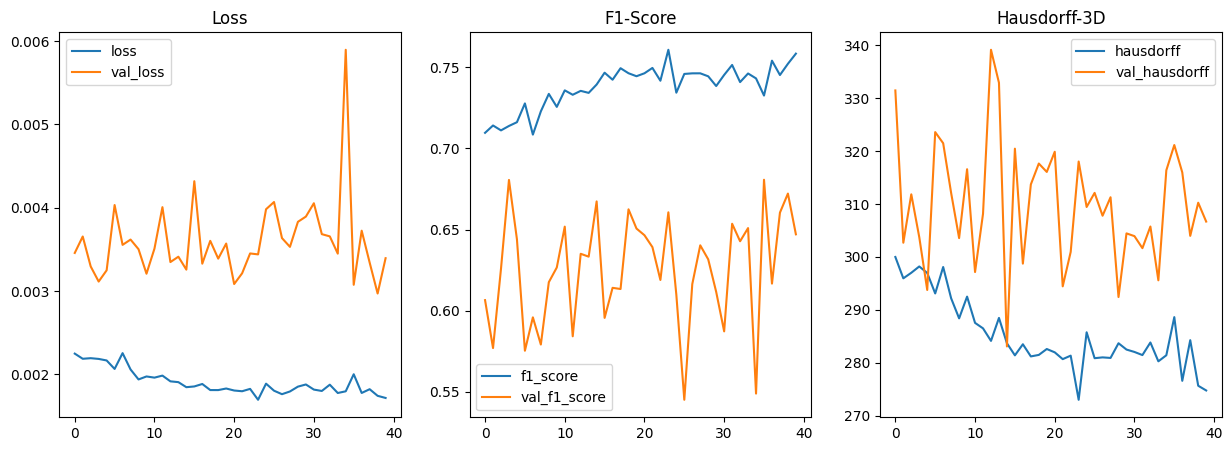

In [ ]:
from matplotlib import pyplot as plt

loss = np.array(history['loss'])
val_loss = np.array(history['val_loss'])

metr_hausdorff = np.array(history['hausdorff_3d'])
metr_val_hausdorff = np.array(history['val_hausdorff_3d'])

metr_f1_score = np.array(history['f1-score'])
metr_val_f1_score = np.array(history['val_f1-score'])

fig = plt.figure(figsize=(15, 5))

plt.subplot(1,3,1)

plt.plot(range(len(loss)), loss, label='loss')
plt.plot(range(len(loss)), val_loss, label='val_loss')
plt.legend()
plt.title('Loss')

plt.subplot(1,3,2)
plt.plot(range(len(metr_f1_score)), metr_f1_score, label='f1_score')
plt.plot(range(len(metr_f1_score)), metr_val_f1_score, label='val_f1_score')
plt.legend()
plt.title('F1-Score')

plt.subplot(1,3,3)
plt.plot(range(len(metr_hausdorff)), metr_hausdorff, label='hausdorff')
plt.plot(range(len(metr_hausdorff)), metr_val_hausdorff, label='val_hausdorff')
plt.legend()
plt.title('Hausdorff-3D')

plt.show()

Quello che si evince, sia per le metriche che per la funzione di loss, è un miglioramento graduale dei valori con il passare del tempo di **addestramento**, come atteso.<br>
Discorso, in parte, diverso per quanto concerne i valori in fase di **validazione**, dove si può notare un andamento più altalenante nel corso delle epoche, ma che comunque evidenzia, in media, un miglioramento delle prestazioni della rete. Riteniamo che una tale altalenanza sia legata all'esiguo numero di volumi appartenenti al validation set, per cui il calcolo dei valori medi possono essere particolarmente variabili.


### Test del modello

A partire dal modello addestrato, di cui abbiamo salvato il miglior checkpoint in fase di addestramento, possiamo procedere alla valutazione delle prestazioni in fase di predizione.

Per far ciò, ricreiamo lo scheletro del modello (inteso come la dichiarazione e la compilazione dello stesso) e carichiamo i pesi con la funzione `load_weights` dell'oggetto `Model`

In [ ]:
model.compile(optimizer = optim, loss=categorical_ce, metrics=metrics)
        
model.load_weights('./models/checkpoints/new_v4_checkpoint_295_hausdorff.hdf5')

Carichiamo un volume di test e le maschere ad esso associate.

In [ ]:
test_volume_path = './dataset/slices/resized_volume_11_13_128_128_72.tif'

test_mask_path = './dataset/masks/resized_volume_11_13_128_128_72.tif'

test_volume = tiff.imread(test_volume_path)

test_mask = tiff.imread(test_mask_path)

Processiamo volume e maschera come fatto dal data generator

In [ ]:
test_volume = test_volume.reshape((1,) + test_volume.shape + (1,))

volume = np.concatenate([test_volume, test_volume], axis=4)

volume = preprocess_input(np.concatenate([volume, test_volume], axis=4))

test_mask = discretize(test_mask)

test_mask = to_categorical(test_mask, num_classes=4)

test_mask = test_mask.reshape((1,) + test_mask.shape)

Effettuiamo, quindi, una valutazione delle prestazioni del modello sul volume e la rispettiva maschera

In [ ]:
metrics = model.evaluate(volume, test_mask, batch_size=1, verbose=1)

1/1 [==============================] - 3s 3s/step - loss: 0.0014 - f1-score: 0.7669 - hausdorff_3d: 202.4994


Osservando i valori per la **Categorical CrossEntropy** e per il **coefficiente di Dice**, è possibile dedurre che è possibile una previsione discreta da parte del modello.

Passiamo, allora, alla generazione vera e propria del volume predetto, usando il metodo `predict` dell'oggetto `Model`

In [ ]:
mask = model.predict(volume, batch_size=1, verbose=0)[0]

Poiché l'output della rete è una distribuzione di probabilità per ogni pixel che ne indica l'appartenenza a una delle quattro classi, usiamo la funzione `argmax` di NumPy per generare un'immagine in cui ogni pixel e assegnato alla classe più probabile

In [ ]:
predicted_classes = np.argmax(mask, axis=-1)

Per valutare visivamente il risultato della previsione, dobbiamo prima riportare il volume di ground truth a 3 dimensioni in 1 canale (il passaggio in categorico lo ha portato a 4D in 4 canali).<br>
Per far ciò, ricorriamo all'operazione inversa fatta in fase di traduzione del volume a dato categorico.

In [ ]:
ground_truth = np.argmax(test_mask.squeeze(), axis=-1)

(64, 128, 128)


Possiamo, quindi, confrontare il risultato della predizione con la ground truth usando il modulo `pyplot` di `matplotlib` che, normalmente, permette di generare una vista navigabile del volume (con rotazioni e zoom in/out) ma che, all'interno di un notebook, genera la proiezione isometrica dello stesso in 2D.

/tmp/ipykernel_139200/3066851300.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10')


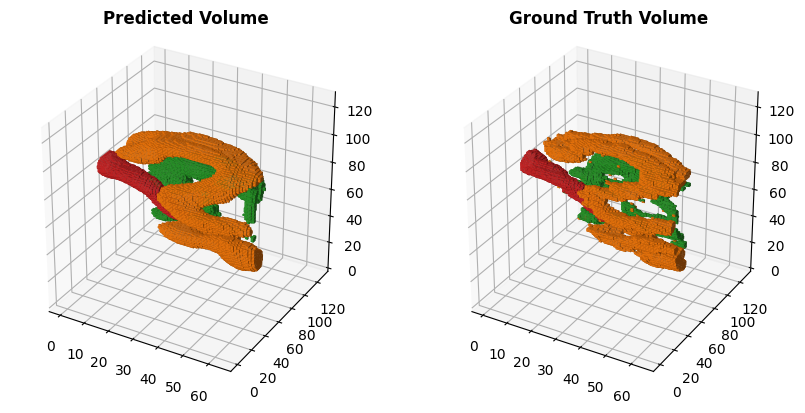

In [ ]:
fig = plt.figure(figsize=(10,5))

cmap = plt.cm.get_cmap('tab10')

ax1 = fig.add_subplot(1,2,1, projection='3d')
ax1.set_box_aspect([1,1,1])
ax1.voxels(predicted_classes, facecolors=cmap(predicted_classes))
ax1.set_title('Predicted Volume', fontweight='bold')


ax2 = fig.add_subplot(1,2,2, projection='3d')
ax2.set_box_aspect([1,1,1])
ax2.voxels(ground_truth, facecolors=cmap(ground_truth))
ax2.set_title('Ground Truth Volume', fontweight='bold')

# Mostrare il grafico
plt.show()

A conferma di quanto ipotizzato osservando le metriche, possiamo notare come il modello abbia predetto discretamente bene il volume fornendo, anzi, forme più smussate dei vari organi. Possiamo, inoltre, valutare il risultato su singola slice, semplicemente selezionando un indice all'interno dei volumi

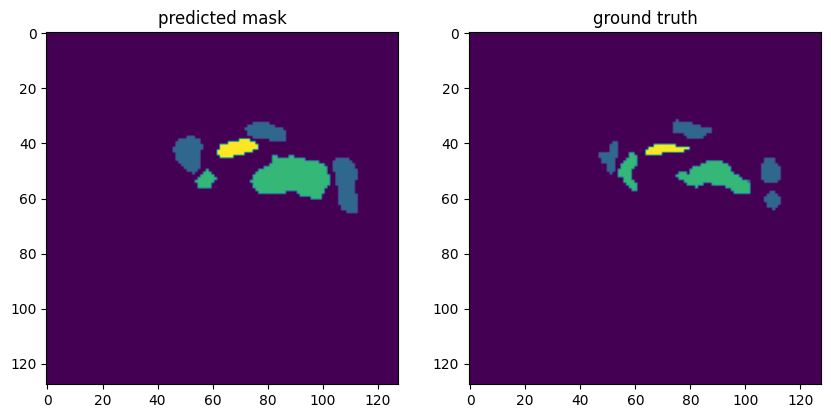

In [ ]:
fig = plt.figure(figsize=(10, 5))

plt.subplot(1,2,1)
plt.imshow(predicted_classes[30])
plt.title('Predicted Mask')

plt.subplot(1,2,2)
plt.imshow(ground_truth[30])
plt.title('Ground Truth')

plt.show()

<style>
  footer {
    color: #0f5b99;
    background-color: #f7f7f7;
    display: flex;
    justify-content: space-between;
    align-items: center;
    padding: 10px;
    box-shadow: 0 2px 4px rgba(0,0,0,0.2);
  }
  
  footer p {
    font-family: 'Montserrat', 'Arial', sans-serif;
    font-size: 16px;
    margin: 10px;
    text-shadow: 1px 1px #f7f7f7;
  }
  
  .team {
    text-align: left;
  }
  
  .subject {
    text-align: center;
  }
  
  .professor {
    text-align: right;
  }
</style>
<a href="#inizio">
  <footer>
    <p class="team"><strong>Vincenzo Fardella</strong> & <strong>Mario Tortorici</strong></p>
    <p class="subject"><strong>Big Data</strong> &copy; <strong>2023</strong></p>
    <p class="professor">Prof. <strong>Roberto Pirrone</strong></p>
  </footer>
</a>